PyMuPDF

In [1]:
import pymupdf

file_path = r"input\道路法.pdf"
doc = pymupdf.open(file_path)
for page in doc:
    print(page.get_text())


昭和二十七年法律第百八十号
道路法
目次
第一章　総則（第一条―第四条）
第二章　一般国道等の意義並びに路線の指定及び認定（第五条―第十一条）
第三章　道路の管理
第一節　道路管理者（第十二条―第二十八条の二）
第二節　道路の構造（第二十九条―第三十一条の二）
第三節　道路の占用（第三十二条―第四十一条）
第四節　道路の保全等（第四十二条―第四十七条の十六）
第五節　道路の立体的区域（第四十七条の十七―第四十八条）
第六節　自動車専用道路（第四十八条の二―第四十八条の十二）
第七節　自転車専用道路等（第四十八条の十三―第四十八条の十六）
第八節　重要物流道路（第四十八条の十七―第四十八条の十九）
第九節　歩行者利便増進道路（第四十八条の二十―第四十八条の二十九）
第九節の二　防災拠点自動車駐車場（第四十八条の二十九の二―第四十八条の二十九の七）
第十節　特定車両停留施設（第四十八条の三十―第四十八条の三十六）
第十一節　利便施設協定（第四十八条の三十七―第四十八条の三十九）
第十二節　自動車駐車場等運営事業（第四十八条の四十―第四十八条の四十五）
第十三節　指定登録確認機関（第四十八条の四十六―第四十八条の五十九）
第十四節　道路協力団体（第四十八条の六十―第四十八条の六十五）
第四章　道路に関する費用、収入及び公用負担（第四十九条―第七十条）
第五章　監督（第七十一条―第七十八条）
第六章　社会資本整備審議会の調査審議等（第七十九条―第八十四条）
第七章　雑則（第八十五条―第九十八条の二）
第八章　罰則（第九十九条―第百九条）
附則
第一章　総則
（この法律の目的）
第一条　この法律は、道路網の整備を図るため、道路に関して、路線の指定及び認定、管理、構造、保全、費用の負担区分等に関する事項
を定め、もつて交通の発達に寄与し、公共の福祉を増進することを目的とする。
（用語の定義）
第二条　この法律において「道路」とは、一般交通の用に供する道で次条各号に掲げるものをいい、トンネル、橋、渡船施設、道路用エレ
ベーター等道路と一体となつてその効用を全うする施設又は工作物及び道路の附属物で当該道路に附属して設けられているものを含むも
のとする。
２　この法律において「道路の附属物」とは、道路の構造の保全、安全かつ円滑な道路の交通の確保その他道路の管理上必要な施設又は工
作物

### pypdfを使ったテキスト抽出
* 前処理からjsonlへの出力まで

In [101]:
from pypdf import PdfReader
import re
import json
import os

# グローバル変数
CHUNK_SIZE = 2000 # 1つのチャンクの最大文字数
zenkakuNum2hankakuNum = str.maketrans("０１２３４５６７８９", "0123456789")
zenkakuAlpha2hankakuAlpha = str.maketrans("ＡＢＣＤＥＦＧＨＩＪＫＬＭＮＯＰＱＲＳＴＵＶＷＸＹＺ", "ABCDEFGHIJKLMNOPQRSTUVWXYZ")
zenkakuAlpha2hankakuAlpha_lowercase = str.maketrans("ａｂｃｄｅｆｇｈｉｊｋｌｍｎｏｐｑｒｓｔｕｖｗｘｙｚ", "abcdefghijklmnopqrstuvwxyz")
output_file_path = r"output\道路法.jsonl"
input_file_path = r"input\道路法.pdf"

# フォルダの準備
os.makedirs("input", exist_ok=True)
os.makedirs("output", exist_ok=True)

############################################
# PDFからテキストを抽出する関数
############################################
def extract_text_from_pdf(file_path: str) -> str:
    reader = PdfReader(file_path)
    number_of_pages = len(reader.pages)
    text = ""
    for i in range(number_of_pages):
        page = reader.pages[i]
        text += page.extract_text()
    return text

############################################
# テキストのクリーニングを行う関数群
############################################
def pre_clean_text(text: str) -> str:
    # 改行の削除
    text = text.replace("\n", "")
    # 全角数字を半角数字に変換
    text = text.translate(zenkakuNum2hankakuNum)
    # 全角アルファベットを半角アルファベットに変換
    text = text.translate(zenkakuAlpha2hankakuAlpha)
    text = text.translate(zenkakuAlpha2hankakuAlpha_lowercase)
    # 全角スペースを半角スペースに変換
    text = text.replace("　", " ")
    return text

# 1. 正規表現を使って章ごとに分割する関数
def split_text_by_chapter(text: str) -> list[str]:

    chapter_pattern = r"第[一二三四五六七八九十]+章\s.*"
    chapters = re.split(chapter_pattern, text)
    # 分割された章のタイトルを取得
    chapter_titles = re.findall(chapter_pattern, text)
    chapters_dict = {}
    for i, chapter in enumerate(chapters[1:], start=0):  # 先頭に余分な要素がある可能性があるため[1:]を使用
        chapters_dict[chapter_titles[i]] = chapter.strip()
    return chapters_dict

# 2. 章をCHUNK_SIZE文字数で分割する関数
def split_large_chunks(chapter_dict: dict[str, str], max_length=CHUNK_SIZE) -> dict[str,str]:
    refined_chunks = {}
    for title, content in chapter_dict.items():

        # textのクリーニング
        content = pre_clean_text(content)

        if len(content) > max_length:
            # 節や項で分割する
            section_pattern = r"(第[一二三四五六七八九十百]+条(の[一二三四五六七八九十百]+)*\s.*)"
            # section_pattern = r"(第[一二三四五六七八九十百]+[一二三四五六七八九十]?(節|条)\s.*)"
            sections = re.split(section_pattern, content)

            # 分割後の結果を一時格納
            sub_chunks = []
            temp_chunk = ""
            for section in sections:
                if len(temp_chunk) + len(section) < max_length:
                    temp_chunk += section
                else:
                    sub_chunks.append(temp_chunk)
                    temp_chunk = section
            # 最後のチャンクを追加
            if temp_chunk:
                sub_chunks.append(temp_chunk)
            refined_chunks[title] = sub_chunks
        else:
            refined_chunks[title] = [content]

    return refined_chunks

# チャンクをJSONL形式に変換する関数
def save_chunks_to_jsonl(chunks: dict[str, list[str]], output_file_path: str):
    with open(output_file_path, "w", encoding="utf-8") as f:
        for chapter_title, sections in chunks.items():
            for section in sections:
                json_line = {"text": section}
                f.write(json.dumps(json_line, ensure_ascii=False) + "\n")
                
       
# テキストのクリーニングを行う関数
def clean_text(text: str) -> str:
    chapters_dict = split_text_by_chapter(text)
    refined_chunks = split_large_chunks(chapters_dict)
    save_chunks_to_jsonl(refined_chunks, output_file_path)
    print(f"jsonlのパス: .\{output_file_path}")
    
    return True

####################
# メイン関数
####################
def main():
    # PDFからテキストを抽出
    text = extract_text_from_pdf(input_file_path)
    # テキストのクリーニング
    flag = clean_text(text)
    if flag:
        print("\nDone")



In [105]:
import re
import json
import os
from pypdf import PdfReader

# グローバル変数
CHUNK_SIZE = 2000  # 1つのチャンクの最大文字数
zenkakuNum2hankakuNum = str.maketrans("０１２３４５６７８９", "0123456789")
zenkakuAlpha2hankakuAlpha = str.maketrans("ＡＢＣＤＥＦＧＨＩＪＫＬＭＮＯＰＱＲＳＴＵＶＷＸＹＺ", "ABCDEFGHIJKLMNOPQRSTUVWXYZ")
zenkakuAlpha2hankakuAlpha_lowercase = str.maketrans("ａｂｃｄｅｆｇｈｉｊｋｌｍｎｏｐｑｒｓｔｕｖｗｘｙｚ", "abcdefghijklmnopqrstuvwxyz")

# 入出力パスの定義
input_file_path = os.path.join("input", "道路法.pdf")
output_file_path = os.path.join("output", "道路法.jsonl")

# フォルダの準備
os.makedirs("input", exist_ok=True)
os.makedirs("output", exist_ok=True)

############################################
# ステップ1: PDFからテキストを抽出する関数
############################################
def extract_text_from_pdf(file_path: str) -> str:
    reader = PdfReader(file_path)
    number_of_pages = len(reader.pages)
    text = ""
    for i in range(number_of_pages):
        page = reader.pages[i]
        text += page.extract_text()
    return text

############################################
# ステップ2: テキストのクリーニングを行う関数
############################################
def pre_clean_text(text: str) -> str:
    # 改行の削除
    text = text.replace("\n", "")
    # 全角数字を半角数字に変換
    text = text.translate(zenkakuNum2hankakuNum)
    # 全角アルファベットを半角アルファベットに変換
    text = text.translate(zenkakuAlpha2hankakuAlpha)
    text = text.translate(zenkakuAlpha2hankakuAlpha_lowercase)
    # 全角スペースを半角スペースに変換
    text = text.replace("　", " ")
    return text

############################################
# ステップ3: 章ごとに分割する関数（正規表現の修正）
############################################
############################################
# ステップ3: 章ごとに分割する関数の修正
############################################
def split_text_by_chapter(text: str) -> dict[str, str]:
    """
    テキストを章ごとに分割し、章タイトルと章内容の辞書を返す関数。
    章タイトルと内容の数が一致するように調整。
    """
    # 正規表現のパターンを修正して章を分割
    chapter_pattern = r"(第[一二三四五六七八九十百]+章\s.*)"
    
    # 章タイトルでテキストを分割し、先頭の空要素を削除
    chapters = re.split(chapter_pattern, text)
    chapters = [chapter.strip() for chapter in chapters if chapter.strip()]  # 空の章を除外
    
    # 分割された章のタイトルを取得
    chapter_titles = re.findall(chapter_pattern, text)
    
    # 章タイトルと章内容の数が一致しない場合の調整
    if len(chapters) != len(chapter_titles) + 1:
        print("Warning: 章のタイトルと内容の数が一致しません。修正を試みます。")
        
        # 余分なテキストが先頭にある場合の削除
        if len(chapters) > len(chapter_titles):
            chapters.pop(0)  # 最初の空要素を削除

    # 章タイトルと内容を辞書に格納
    chapters_dict = {}
    for i, chapter in enumerate(chapters):
        if i < len(chapter_titles):
            chapters_dict[chapter_titles[i]] = chapter
        else:
            print(f"Warning: タイトルなしの章があります。内容: {chapter[:50]}...")  # デバッグ用メッセージ
            chapters_dict[f"タイトルなし_{i}"] = chapter  # タイトルがない章に対して仮のタイトルを設定

    return chapters_dict

############################################
# ステップ4: 章をCHUNK_SIZE文字数で分割する関数（再帰分割を追加）
############################################
############################################
# ステップ4: 章をCHUNK_SIZE文字数で分割する関数の修正
############################################
def split_large_chunks(chapter_dict: dict[str, str], max_length=CHUNK_SIZE) -> dict[str, list[str]]:
    """
    各章の内容を指定された最大文字数（max_length）に収まるように分割する関数。
    必要に応じて、再帰的に分割を行う。
    """
    refined_chunks = {}
    for title, content in chapter_dict.items():
        # テキストのクリーニングを行う
        content = pre_clean_text(content)

        # CHUNK_SIZEを超えている場合に分割処理を行う
        if len(content) > max_length:
            # 条や節で分割するパターンを定義
            section_pattern = r"(第[一二三四五六七八九十百]+条(の[一二三四五六七八九十百]+)*\s.*)"
            sections = re.split(section_pattern, content)
            
            # None の要素を削除
            sections = [section for section in sections if section]  # None を除外

            # 分割されたテキストを一時格納
            sub_chunks = []
            temp_chunk = ""
            for section in sections:
                if len(temp_chunk) + len(section) <= max_length:
                    temp_chunk += section
                else:
                    sub_chunks.append(temp_chunk)
                    temp_chunk = section
            # 最後のチャンクを追加
            if temp_chunk:
                sub_chunks.append(temp_chunk)

            # 各チャンクをさらに分割（再帰的な分割）
            refined_chunks[title] = []
            for chunk in sub_chunks:
                if len(chunk) > max_length:  # さらに細かく分割する必要がある場合
                    refined_chunks[title].extend(split_large_chunks({title: chunk}, max_length)[title])
                else:
                    refined_chunks[title].append(chunk)
        else:
            refined_chunks[title] = [content]

    return refined_chunks


############################################
# ステップ5: チャンクをJSONL形式に保存する関数
############################################
def save_chunks_to_jsonl(chunks: dict[str, list[str]], output_file_path: str):
    with open(output_file_path, "w", encoding="utf-8") as f:
        for chapter_title, sections in chunks.items():
            for section in sections:
                json_line = {"text": section}
                f.write(json.dumps(json_line, ensure_ascii=False) + "\n")

############################################
# ステップ6: テキストのクリーニングと分割を行う関数
############################################
def clean_text(text: str) -> str:
    chapters_dict = split_text_by_chapter(text)  # 章ごとに分割
    refined_chunks = split_large_chunks(chapters_dict)  # 各章をCHUNK_SIZEに分割
    save_chunks_to_jsonl(refined_chunks, output_file_path)  # JSONL形式で保存
    print(f"jsonlのパス: {output_file_path}")

    return True

############################################
# ステップ7: メイン関数の定義
############################################
def main():
    # PDFからテキストを抽出
    text = extract_text_from_pdf(input_file_path)
    # テキストのクリーニングと分割
    if clean_text(text):
        print("\nDone")

# メイン関数を実行
if __name__ == "__main__":
    main()


第四十九条　 道路の管理に関する費用は、この法律及び公共土木施...
第七十一条　 道路管理者は、次の各号のいずれかに該当する者に対して、この...
第七十九条　 社会資本整備審議会は、国土交通大臣の諮問に応じ、国...
第八十五条　 国道に附属する道路の附属物の新設又は改築は、国土交通大...


RecursionError: maximum recursion depth exceeded while calling a Python object

In [102]:
main()

TypeError: object of type 'NoneType' has no len()

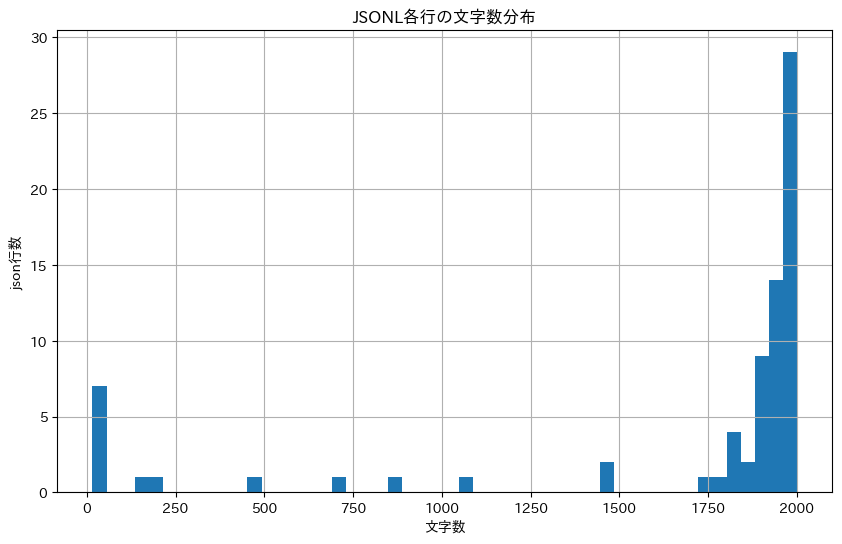

[(66, 2000)]


In [187]:
import json
import matplotlib.pyplot as plt
import japanize_matplotlib

def read_jsonl_file(file_path):
    lines = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            json_obj = json.loads(line.strip()) 
            lines.append(json_obj['text'])  
    return lines

def check_line_length(lines, max_length=2000):
    long_lines = [] 
    for i, line in enumerate(lines):
        if len(line) >= max_length:
            long_lines.append((i, len(line)))
    return long_lines

def visualize_line_lengths(lines):
    # 各行の文字数を計算
    line_lengths = [len(line) for line in lines]
    
    # ヒストグラムの作成
    plt.figure(figsize=(10, 6))
    plt.hist(line_lengths, bins=50)
    plt.title('JSONL各行の文字数分布')
    plt.xlabel('文字数')
    plt.ylabel('json行数')
    plt.grid(True)
    plt.show()

jsonl_file_path = "output\\道路法.jsonl"  
lines = read_jsonl_file(jsonl_file_path)

# 各行の文字数を可視化
visualize_line_lengths(lines)
print(check_line_length(lines))


In [190]:
import re
import json
import os
import sys
from pypdf import PdfReader

# 無限ループ防止
sys.setrecursionlimit(3000)

# 定数
CHUNK_SIZE = 2000  # 1つのチャンクの最大文字数
# グローバル変数
zenkakuNum2hankakuNum = str.maketrans("０１２３４５６７８９", "0123456789")
zenkakuAlpha2hankakuAlpha = str.maketrans("ＡＢＣＤＥＦＧＨＩＪＫＬＭＮＯＰＱＲＳＴＵＶＷＸＹＺ", "ABCDEFGHIJKLMNOPQRSTUVWXYZ")
zenkakuAlpha2hankakuAlpha_lowercase = str.maketrans("ａｂｃｄｅｆｇｈｉｊｋｌｍｎｏｐｑｒｓｔｕｖｗｘｙｚ", "abcdefghijklmnopqrstuvwxyz")
# 入出力パス
input_file_path = os.path.join("input", "道路法.pdf")
output_file_path = os.path.join("output", "道路法.jsonl")

# フォルダ準備
os.makedirs("input", exist_ok=True)
os.makedirs("output", exist_ok=True)

############################################
# PDFからテキストを抽出する関数
############################################
def extract_text_from_pdf(file_path: str) -> str:
    reader = PdfReader(file_path)
    number_of_pages = len(reader.pages)
    text = ""
    for i in range(number_of_pages):
        page = reader.pages[i]
        text += page.extract_text()
    return text

############################################
# テキストのクリーニングを行う関数
############################################
def pre_clean_text(text: str) -> str:
    text = text.replace("\n", "")
    text = text.translate(zenkakuNum2hankakuNum)  # 全角数字 -> 半角数字に変換
    text = text.translate(zenkakuAlpha2hankakuAlpha)  # 全角アルファベット -> 半角
    text = text.translate(zenkakuAlpha2hankakuAlpha_lowercase)  # 全角小文字アルファベット -> 半角小文字アルファベット
    text = text.replace("　", " ")  # 全角スペース-> 半角スペースに変換
    text = text.replace(" ）", "）")  # 余分なスペースの削除（注意：全角の）である。よく見るとかなりある）後の正規表現で影響するので削除
    text = text.replace("。。", "。")  # 連続する「。」の削除（よく見ると、たまにある）
    text = text.replace("、、", "、")  # 連続する「、」の削除（念のため）

    return text

############################################
# 章ごとに分割する関数
############################################
def split_text_by_chapter(text: str):
    # 「第〇章」で分割し、分割された章タイトルを含む位置情報を取得
    text = pre_clean_text(text)
    pattern = r"(第[一二三四五六七八九十百千]+章 [^第]*)"
    matches = re.finditer(pattern, text)
    
    chapters = []
    prev_start = None
    prev_match = None

    # 章タイトルの位置を利用して、各章の内容を抽出
    for match in matches:
        if prev_start is not None:
            # 前回の章タイトルから次の章タイトルまでを抽出
            chapter_content = text[prev_start:match.start()].strip()
            chapters.append(chapter_content)
        prev_start = match.start()
        prev_match = match

    # 最後の章の内容を取得
    if prev_match:
        chapter_content = text[prev_start:].strip()
        chapters.append(chapter_content)
    
    return chapters

############################################
# 2000文字超えてたら「。」で分割する関数
############################################
# チャンクが2000文字以上の場合に、句読点「。」を基準に分割する関数
def split_large_chunks(chunk, max_length=2000):
    if len(chunk) <= max_length:
        return chunk
    
    # 句読点「。」でチャンクを分割
    sentences = chunk.split("。")
    current_chunk = ""
    split_chunks = []

    for sentence in sentences:
        # 文末に「。」を戻す（splitで消えてしまう）
        sentence = sentence + "。"
        
        # 追加しても2000文字を超えない場合は、現在のチャンクに追加
        if len(current_chunk) + len(sentence) <= max_length:
            current_chunk += sentence
        else:
            # 現在のチャンクが2000文字を超える場合は、新しいチャンクを開始
            split_chunks.append(current_chunk)
            current_chunk = sentence

    # 最後に残ったチャンクを追加
    if current_chunk:
        split_chunks.append(current_chunk)

     # 分割されたチャンクの調整
    adjusted_chunks = adjust_chunk(split_chunks)

    return adjusted_chunks

###########################
# チャンクの境界を調整する関数
###########################
def adjust_chunk(chunks, max_length=2000):
    adjusted_chunks = []
    current_chunk = ""

    for chunk in chunks:
        # チャンクの先頭が「)」、「、」、「。」など不適切な文字で始まる場合、前のチャンクと結合する
        if re.match(r"^[)、。]", chunk):
            # 結合しても2000文字を超えない場合のみ結合
            if len(current_chunk) + len(chunk) <= max_length:
                current_chunk += chunk
            else:
                # 結合すると2000文字を超えてしまう場合は、前のチャンクを確定させる
                if current_chunk:
                    adjusted_chunks.append(current_chunk)
                # 現在のチャンクをそのまま新しいチャンクとする
                current_chunk = chunk
        else:
            # 不適切な文字で始まっていない場合
            if current_chunk:
                # 現在のチャンクを追加して、新しいチャンクを開始
                adjusted_chunks.append(current_chunk)
            current_chunk = chunk

    # 最後のチャンクを追加
    if current_chunk:
        adjusted_chunks.append(current_chunk)

    return adjusted_chunks

############################################
# 短すぎるチャンクの切り落とし（目次を削除したい）
################################
def remove_short_chunks(chunks, min_length=100):
    refined_chunks = []
    for chunk in chunks:
        if len(chunk) >= min_length:
            refined_chunks.append(chunk)
    return refined_chunks

############################################
# チャンクをJSONL形式に保存する関数
############################################
def save_chunks_to_jsonl(chunks: list[str], output_file_path: str):
    with open(output_file_path, "w", encoding="utf-8") as f:
        chunks = remove_short_chunks(chunks) # 目次のような短いチャンクを削除のつもり
        for chunk in chunks:
            if len(chunk) > CHUNK_SIZE:
                smaller_chunk = split_large_chunks(chunk)
                for sc in smaller_chunk:
                    json_line = {"text": sc}
                    f.write(json.dumps(json_line, ensure_ascii=False) + "\n")
            else:
                json_line = {"text": chunk}
                f.write(json.dumps(json_line, ensure_ascii=False) + "\n")
    return True

############################################
# テキストのクリーニングと分割を行う関数
############################################
def clean_text(text: str) -> str:
    chapters_list = split_text_by_chapter(text)  # 章ごとに分割
    if save_chunks_to_jsonl(chapters_list, output_file_path):  # JSONL形式で保存
        print(f"jsonlのパス: {output_file_path}")
    else:
        print("JSONの出力失敗")
    return True

############################################
# メイン関数
############################################
def main():
    text = extract_text_from_pdf(input_file_path)
    if clean_text(text):
        print("\nDone")


In [191]:
if __name__ == "__main__":
    main()

jsonlのパス: output\道路法.jsonl

Done
